# 1. SETTINGS

In [1]:
# settings for Google Colab
from google.colab import drive
drive.mount('/gdrive')
import os
os.chdir("/gdrive/My Drive/Colab Notebooks/DMC_2019/codes")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA, FastICA, FactorAnalysis
from sklearn.metrics import log_loss
from sklearn.neighbors import NearestNeighbors
import copy
import scipy.stats
import os
import time

In [0]:
# helper functions
import functions
from functions import *

In [0]:
# pandas options
pd.set_option('display.max_columns', None)

In [0]:
# dark background style
plt.style.use('dark_background')

In [0]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [0]:
# garbage collection
import gc
gc.enable()

# 2. DATA PREPARATION

In [40]:
# import CSV
df = pd.read_csv('../data/data_v3.csv')
print(df.shape)

(500000, 13)


In [0]:
# target variable
target = 'fraud'

In [42]:
# partitioning
train = df[df[target].isnull() == False]
test  = df[df[target].isnull() == True]
print(train.shape)
print(test.shape)

(1879, 13)
(498121, 13)


In [0]:
#train['qM_sT'] = train.quantityModifications / train.totalScanTimeInSeconds
#test['qM_sT']  = test.quantityModifications / test.totalScanTimeInSeconds

#train['sWr_sT'] = train.quantityModifications / train.totalScanTimeInSeconds
#test['sWr_sT']  = test.scansWithoutRegistration / test.totalScanTimeInSeconds

#train['wA_sT'] = train.weird_actions / train.totalScanTimeInSeconds
#test['wA_sT']  = test.weird_actions / test.totalScanTimeInSeconds

In [44]:
# create neigbhor-based featurs (by Liza)

features_for_n = ['grandTotal',
                 'lineItemVoids',
                 'lineItemVoidsPerPosition',
                 'quantityModifications',
                 'scannedLineItemsPerSecond',
                 'scansWithoutRegistration',
                 'totalScanTimeInSeconds',
                 'valuePerSecond',
                 'total_items',
                 'weird_actions']

'''train['neighbors_fraud'] = 0
test['neighbors_fraud'] = 0

print('create train neighboring features')
nbrs = NearestNeighbors(n_neighbors=101, algorithm='ball_tree').fit(train.loc[:,features_for_n].values)
for i, obs in enumerate(train.index):
  distances, indices = nbrs.kneighbors(train.loc[[obs], features_for_n])
  train.loc[obs, 'neighbors_fraud'] = train.loc[indices[0][indices[0]!=obs], 'fraud'].mean()
  if i%100==0:
    print(i)'''
        
#print('create train neighboring features')
#nbrs = NearestNeighbors(n_neighbors=16, algorithm='ball_tree').fit(train.loc[:,features_for_n])
#for i, obs in enumerate(train.index):
#  distances, indices = nbrs.kneighbors(train.loc[[obs], features_for_n])
#  train.loc[obs, 'neighbors_fraud15'] = train.loc[indices[0][indices[0]!=obs], 'fraud'].mean()
#  if i%100==0:
#    print(i)
    
#print('create test neighboring features')  
#nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(train.loc[:,features_for_n])
#for i, obs in enumerate(test.index):
#  distances, indices = nbrs.kneighbors(test.loc[[obs], features_for_n])
#  test.loc[obs, 'neighbors_fraud'] = train.loc[indices[0], 'fraud'].mean()
#  if i%1000==0:
#    print(i)

"train['neighbors_fraud'] = 0\ntest['neighbors_fraud'] = 0\n\nprint('create train neighboring features')\nnbrs = NearestNeighbors(n_neighbors=101, algorithm='ball_tree').fit(train.loc[:,features_for_n].values)\nfor i, obs in enumerate(train.index):\n  distances, indices = nbrs.kneighbors(train.loc[[obs], features_for_n])\n  train.loc[obs, 'neighbors_fraud'] = train.loc[indices[0][indices[0]!=obs], 'fraud'].mean()\n  if i%100==0:\n    print(i)"

In [0]:
# target variable
y = train[target]
del train[target], test[target]

# 3. MODELING

### PARAMETERS

In [0]:
#train.trustLevel = train.trustLevel.astype('category')
#test.trustLevel = test.trustLevel.astype('category')
train['tL_b_2'] = 0
test['tL_b_2']  = 0
train.loc[(train.trustLevel==1)|(train.trustLevel==2),'tL_b_2'] = 0
test.loc[(test.trustLevel==1)|(test.trustLevel==2),'tL_b_2']  = 0
train.trustLevel = np.log(train.trustLevel)
test.trustLevel = np.log(test.trustLevel)

In [47]:
# drop bad features
excluded_feats = ['id']
features = [f for f in train.columns if f not in excluded_feats]
print(train[features].shape)

(1879, 12)


In [0]:
### PARAMETERS

# settings
cores = 12
seed  = 23

# cross-validation
num_folds = 20
shuffle   = True

# muner of rounds
max_rounds = 500
#stopping   = 1000
verbose    = 200

# LGB parameters
lgb_params = {
    'boosting_type':     'rf',
    'objective':         'binary',
    'metrics':           'binary_logloss',
    'bagging_freq':      1,
    'bagging_fraction':  0.85,
    'feature_fraction':  0.4,
  #  'lambda_l1':         0.1,
  #  'lambda_l2':         0.1,
    'min_split_gain':    0,
    'min_child_weight':  0,
    'min_child_samples': 70,
    'silent':            True,
    'verbosity':         -1,
    'learning_rate':     0.01,
    'max_depth':         30,
    'num_leaves':        30,
    'scale_pos_weight':  1,
    'n_estimators':      max_rounds,
    'nthread' :          cores,
    'random_state':      seed,
    'subsample_for_bin': 200,
   # 'subsample':         0.1,
   # 'subsample_freq':    10,

}

# data partitinoing
folds = StratifiedKFold(n_splits = num_folds, random_state = seed, shuffle = shuffle)

In [0]:
# placeholders
clfs = []
valid_profit = np.zeros(num_folds) 
preds_test   = np.zeros(test.shape[0])
preds_oof    = np.zeros(train.shape[0])
importances  = pd.DataFrame()

In [0]:
# SMOTE settings
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 23, n_jobs = 10, sampling_strategy = 0.1)

### CROSS-VALIDATION

In [51]:
### CROSS-VALIDATION LOOP
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train, y)):
  
    
    # data partitioning
    trn_x, trn_y = train[features].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = train[features].iloc[val_idx], y.iloc[val_idx]
    
    ## remove outliers
    #out_idx = (np.abs(scipy.stats.zscore(trn_x)) < 10).all(axis = 1)
    #trn_x = trn_x[out_idx]
    #trn_y = trn_y[out_idx]
    
    # scale data
    scaler   = RobustScaler()
    trn_x    = pd.DataFrame(scaler.fit_transform(trn_x),      columns = features)
    val_x    = pd.DataFrame(scaler.transform(val_x),          columns = features)
    tmp_test = pd.DataFrame(scaler.transform(test[features]), columns = features)
    
        
    # augment training data with SMOTE
    trn_x, trn_y = sm.fit_sample(trn_x, trn_y)
    trn_x = pd.DataFrame(trn_x, columns = features)
    trn_y = pd.Series(trn_y)
    
    # factor decomposition
    tmp_features = copy.deepcopy(features)
    #if False:
    #    decomp = FactorAnalysis(n_components = 11)
    #    decomp.fit(trn_x)
    #    trn_x = decomp.transform(trn_x)
    #    val_x = decomp.transform(val_x)
    #    tmp_test = decomp.transform(tmp_test)
    #    tmp_features = ['pc'+str(i) for i in range(decomp.n_components)]
    
    # add noise to train to reduce overfitting
    #trn_x += np.random.normal(0, 0.01, trn_x.shape)
    
    # mean target encoding
    #trn_x, val_x, tmp_test = mean_target_encoding(trn_x, val_x, test, features = ['trustLevel'], target = 'fraud', folds = 5)
    #features = [f for f in trn_x.columns if f not in excluded_feats]
        
    # train lightGBM
    print('Custom early stopping: select the best out of %.0f iterations...' % max_rounds)
    clf = lgb.LGBMClassifier(**lgb_params) 
    clf = clf.fit(trn_x, trn_y, 
                  eval_set              = [(trn_x, trn_y), (val_x, val_y)], 
                  eval_metric           = prediction_reward, 
                  #eval_metric           = "logloss", 
                  #early_stopping_rounds = stopping,
                  verbose               = verbose)
    clfs.append(clf)
    
    # predict validation from the best iteration
    best_iter = clf.best_iteration_
    best_iter = np.argmax(clf.evals_result_['valid_1']['profit']) + 1
    val_preds = clf.predict_proba(val_x, num_iteration = best_iter)[:, 1]
    print('Best iteration is:')
    print('[' + str(best_iter) + ']   valid_1 profit: ' + str(prediction_reward(val_y, val_preds)[1].astype('int')) + 
          "; log_loss = ", str(np.round(log_loss(val_y, val_preds), 6)))
       
    
############ PERFORM 1 ITERATRION OF SELF-TRAINING

    # predict unlabeled data
    tmp_preds_test = clf.predict_proba(tmp_test, num_iteration = best_iter)[:, 1]

    # extract most confident preds
    perc_ones  = 0.0001
    perc_zeros = 0.0001
    pmax = np.quantile(tmp_preds_test, 1 - perc_ones)
    pmin = np.quantile(tmp_preds_test, perc_zeros)
    tmp_preds_test[tmp_preds_test >= pmax] = 1
    #tmp_preds_test[tmp_preds_test <= pmin] = 0
    confident_ones  = np.where(tmp_preds_test == 1)
    #confident_zeros = np.where(tmp_preds_test == 0)
    confident_ones  = confident_ones[0][0:np.round(len(tmp_test)  * perc_ones).astype('int')]
    #confident_zeros = confident_zeros[0][0:np.round(len(tmp_test) * perc_zeros).astype('int')]
    confident_idx   = confident_ones #np.concatenate((confident_ones, confident_zeros))

    # append new data to train
    test_X = tmp_test.iloc[confident_idx]
    test_y = pd.Series(tmp_preds_test[confident_idx])
    trn_x  = trn_x.append(test_X)
    trn_y  = trn_y.append(test_y)
    print('--------------------------------')
    print('Added %.0f cases to training data...' % len(test_y))
    print('--------------------------------')

    # retrain lightGBM
    print('Custom early stopping: select the best out of %.0f iterations...' % max_rounds)
    clf = lgb.LGBMClassifier(**lgb_params) 
    clf = clf.fit(trn_x, trn_y, 
                  eval_set              = [(trn_x, trn_y), (val_x, val_y)], 
                  eval_metric           = prediction_reward, 
                  verbose               = verbose)

    # find the best iteration
    best_iter = np.argmax(clf.evals_result_['valid_1']['profit']) + 1
    print('Best iteration is:')
    print('[' + str(best_iter) + ']   valid_1 profit: ' + 
          str(prediction_reward(val_y, clf.predict_proba(val_x, num_iteration = best_iter)[:, 1])[1].astype('int')) + 
          "; log_loss = ", str(np.round(log_loss(val_y, clf.predict_proba(val_x, num_iteration = best_iter)[:, 1]), 6)))
    
############ PERFORM 1 ITERATRION OF SELF-TRAINING


    # save predictions
    preds_oof[val_idx]    = clf.predict_proba(val_x, num_iteration = best_iter)[:, 1]
    valid_profit[n_fold]  = prediction_reward(val_y, preds_oof[val_idx])[1]
    preds_test           += clf.predict_proba(tmp_test, num_iteration = best_iter)[:, 1] / folds.n_splits 

    ## importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df['Feature'] = tmp_features
    fold_importance_df['Importance'] = clf.feature_importances_
    fold_importance_df['Fold'] = n_fold + 1
    importances = pd.concat([importances, fold_importance_df], axis = 0)
    
    # print performance
    print('--------------------------------')
    print('FOLD%2d: PROFIT = %.0f' % (n_fold + 1, valid_profit[n_fold]))
    print('--------------------------------')
    print('')
        
    # clear memory
    del trn_x, trn_y, val_x, val_y
    gc.collect()
    
    # uncomment for mean target encoding
    #features = [f for f in train.columns if f not in excluded_feats]
    
    
# print overall performance    
cv_perf = np.sum(valid_profit)
print('--------------------------------')
print('TOTAL PROFIT = %.0f' % cv_perf)
print('--------------------------------')

Custom early stopping: select the best out of 500 iterations...
[200]	training's binary_logloss: 0.116339	training's profit: 495	valid_1's binary_logloss: 0.135753	valid_1's profit: 0
[400]	training's binary_logloss: 0.115682	training's profit: 530	valid_1's binary_logloss: 0.134678	valid_1's profit: 0
Best iteration is:
[16]   valid_1 profit: 10; log_loss =  0.132662
--------------------------------
Added 50 cases to training data...
--------------------------------
Custom early stopping: select the best out of 500 iterations...
[200]	training's binary_logloss: 0.124631	training's profit: 595	valid_1's binary_logloss: 0.13886	valid_1's profit: 0
[400]	training's binary_logloss: 0.124101	training's profit: 615	valid_1's binary_logloss: 0.14035	valid_1's profit: 0
Best iteration is:
[44]   valid_1 profit: 10; log_loss =  0.139158
--------------------------------
FOLD 1: PROFIT = 10
--------------------------------

Custom early stopping: select the best out of 500 iterations...
[200]	tr

In [52]:
##### RECHECK PROFIT  
prediction_reward(y, preds_oof)


###### TRACKING RESULTS (20 folds, strat = True, seed = 23)

# V1: rf, 20 folds, 500 estimators: 335
# V2: rf, 20 folds, 500 estimators, logarithm of trustlevel: 355
# V3: rf, 20 folds, 500 estimators, logarithm of trustlevel, subsample_for_bin 2000: 345 **no improvement**
# V4: rf, 20 folds, 500 estimators, logarithm of trustlevel, without SMOTE: 315 **no improvement**
# V5: rf, 18 folds, 500 estimators, logarithm of trustlevel: 305 **no improvement**
# V6: rf, 10 folds, 500 estimators, logarithm of trustlevel: 235 **no improvement**
# V7: rf, 26 folds, 500 estimators, logarithm of trustlevel: 315 **no improvement**
# V8: rf, 20 folds, 500 estimators, logarithm of trustlevel, semi-super 100 zeros and ones: 205 **no improvement**
# V9: rf, 20 folds, 500 estimators, logarithm of trustlevel, semi-super 100 щтдя ones: 235 **no improvement**

('profit', 235.0, True)

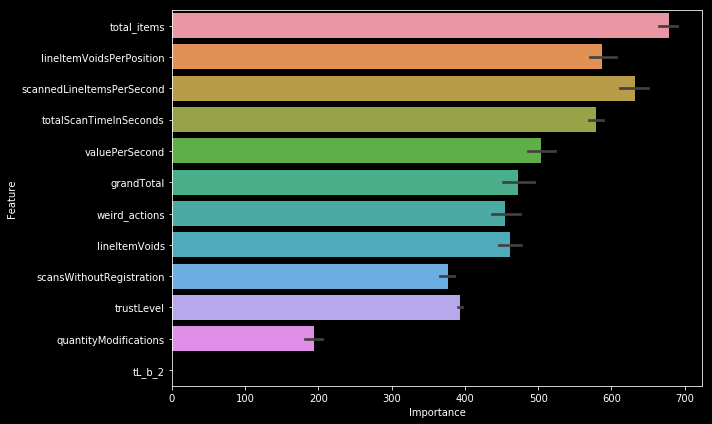

In [53]:
##### VARIABLE IMPORTANCE

# load importance    
top_feats = 100
cols = importances[['Feature', 'Importance']].groupby('Feature').mean().sort_values(by = 'Importance', ascending = False)[0:top_feats].index
importance = importances.loc[importances.Feature.isin(cols)]
    
# plot variable importance
plt.figure(figsize = (10, 6))
sns.barplot(x = 'Importance', y = 'Feature', data = importance.sort_values(by = 'Importance', ascending = False))
plt.tight_layout()

# save plot as pdf
plt.savefig('../var_importance_RF.pdf')

### CUTOFF OPTIMIZATION

- optimal cutoff = 0.5000
- optimal profit = 235.0000


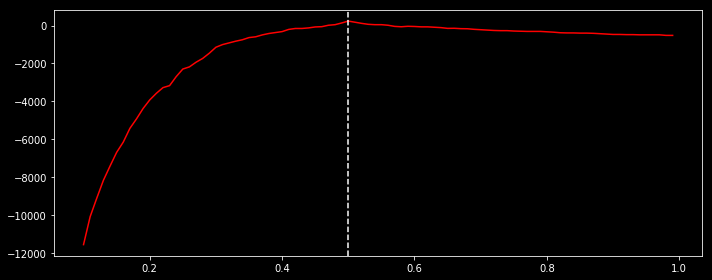

In [54]:
##### OPTIMIZE CUTOFF

# set step
step = 100

# search
cutoffs = []
profits = []
for i in range(0, step):
    cutoffs.append(i / step)
    profits.append(recompute_reward(y, preds_oof, cutoff = cutoffs[i]))
        
# results
plt.figure(figsize = (10,4))
sns.lineplot(x = cutoffs[10:step], y = profits[10:step], color = 'red')
plt.tight_layout()
plt.axvline(x = cutoffs[np.argmax(profits)], color = 'white', linestyle = '--')
print('- optimal cutoff = %.4f' % cutoffs[np.argmax(profits)])
print('- optimal profit = %.4f' % profits[np.argmax(profits)])
plt.savefig('../cutoff_selection_RF.pdf')

# update performance
cv_perf = recompute_reward(y, preds_oof, cutoff = cutoffs[np.argmax(profits)])

# 4. SUBMISSION

In [0]:
# file name
model = 'rf_v9'
perf  = str(round(cv_perf, 0).astype('int'))
name  = model + '_' + perf

In [56]:
# export OOF preds
oof = pd.DataFrame({'id': train['id'], 'fraud': preds_oof})
oof.to_csv('../oof_preds/' + str(name) + '.csv', index = False)
oof.head()

,id,fraud
0,lab_0,0.114742
1,lab_1,0.045943
2,lab_2,0.065375
3,lab_3,0.249765
4,lab_4,0.263138


In [57]:
# check submission
sub = pd.DataFrame({'id': test['id'], 'fraud': preds_test})
sub['fraud'][sub['fraud'] >  cutoffs[np.argmax(profits)]] = 1
sub['fraud'][sub['fraud'] <= cutoffs[np.argmax(profits)]] = 0
sub['fraud'] = sub['fraud'].astype('int')
sub.head()

,id,fraud
1879,unlab_0,0
1880,unlab_1,0
1881,unlab_2,0
1882,unlab_3,0
1883,unlab_4,0


In [58]:
# export submission
sub = sub[['fraud']]
sub.to_csv('../submissions/' + str(name) + '.csv', index = False)
sub.shape

(498121, 1)

In [59]:
# check correlation with previous submission
prev_sub = pd.read_csv('../submissions/rf_v2_355.csv')
cor = np.sum(prev_sub[target] == sub.reset_index()[target]) / len(sub)
print("Share of the same predictions: " + str(np.round(cor, 6)))

Share of the same predictions: 0.986425
